In [82]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm # from tqdm import tqdm_notebook as tqdm

from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.backend import sin,mean
from tensorflow.keras.layers import Input, Reshape, LeakyReLU, Activation, Dropout, Flatten
from tensorflow.keras.layers import Dense, BatchNormalization, Conv1D

from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import TensorBoard

In [4]:
b = 1
h = 0.005
ϵ = 0.8
d = 0.6

steps = 50000
XY = np.empty((2, steps))
XY[:,0] = 50, 100
dt = 0.001

In [5]:
import numpy as np
def get_rates(x, y, b, h, ϵ, d): ###
    return np.array([
      b*x,          # prey born
      (1-ϵ)*h*x*y,  # prey killed, no predator born
      ϵ*h*x*y,      # prey killed, predator born
      d*y,          # predator killed
    ])



def draw_time(rates): ###
#     assert rates.sum() > 0, rates
    return np.random.exponential( 1/rates.sum() )

def draw_reaction(rates): ###
    rates /= rates.sum()
    return np.random.multinomial(1, rates).argmax()

updates = np.array([
  [ 1, 0],   # prey born
  [-1, 0],   # prey killed, no predator born
  [-1, 1],   # prey killed, predator born
  [ 0,-1],   # predator killed
])


def gillespie_step(x, y, b, h, ϵ, d): ###
    rates = get_rates(x, y, b, h, ϵ, d)
    Δt = draw_time(rates)
    ri = draw_reaction(rates)
    Δx, Δy = updates[ri]
    return Δt, Δx, Δy


def gillespie_ssa(b, h, ϵ, d, times_,t0=0, x0=50, y0=100, t_steps=steps, tmax=steps*dt,padding=False): ###
    xx = np.full(steps,0,dtype='int')
    yy = np.full(steps,0,dtype='int')

    t = 0
    i = 0
    xx[0] = x0
    yy[0] = y0

    while t<tmax and yy[i]!=0:
        
        if times_[i] <= t:
            i += 1
            xx[i] = xx[i-1]
            yy[i] = yy[i-1]
        else:
            # update
            Δt, Δx, Δy = gillespie_step(xx[i], yy[i], b, h, ϵ, d)

            t     = t+Δt
            xx[i] = xx[i]+Δx
            yy[i] = yy[i]+Δy

    if i <= steps and not padding:
        return np.array([times_[:i+1],xx[:i+1],yy[:i+1]])       
    else:
        return np.array([times_,xx,yy])

times = np.linspace(0, steps*dt, steps)
t,x,y = gillespie_ssa(b, h, ϵ, d,times_=times)


x_max,y_max = x.max(),y.max()
x_,y_ = x / x_max, y / y_max

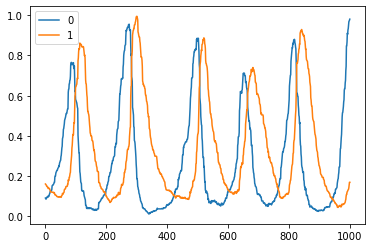

In [6]:
def sample_data_pp(num=1000):
    indices = np.sort(np.random.choice(len(x_),num,replace=False))
    return np.array([np.array(x_[indices]),np.array(y_[indices])])

# plt.plot(np.transpose(sample_data()));
ax = pd.DataFrame(np.transpose(sample_data_pp())).plot()

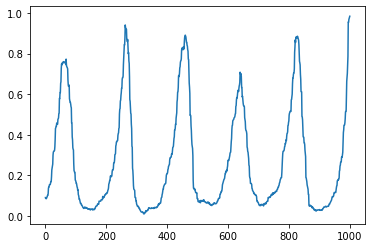

In [7]:
t = sample_data_pp(num=1000)
plt.plot(np.transpose(t[0]));

In [8]:
t, t.mean(),t.std()

(array([[0.09123435, 0.09123435, 0.08586762, ..., 0.97316637, 0.980322  ,
         0.98389982],
        [0.16811092, 0.16811092, 0.15771231, ..., 0.15771231, 0.16984402,
         0.17157712]]),
 0.29774215065898185,
 0.259370796359289)

In [9]:
def create_G(num=100):
    G_in = Input(shape=15)
    x = Reshape((-1,1))(G_in)
    x = Conv1D(2,3,activation=LeakyReLU())(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Conv1D(4,3,activation=LeakyReLU())(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Conv1D(8,3,activation=LeakyReLU())(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Conv1D(16,3,activation=LeakyReLU())(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Conv1D(32,3,activation=LeakyReLU())(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Conv1D(64,3,activation=LeakyReLU())(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Conv1D(100,3,activation='tanh')(x)
    x = Flatten()(x)
    G = Model(G_in,x,name='Generator')
    G.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=0.001))
    return G

G = create_G()
G.summary()

Model: "Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 15)]              0         
_________________________________________________________________
reshape (Reshape)            (None, 15, 1)             0         
_________________________________________________________________
conv1d (Conv1D)              (None, 13, 2)             8         
_________________________________________________________________
batch_normalization (BatchNo (None, 13, 2)             8         
_________________________________________________________________
dropout (Dropout)            (None, 13, 2)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 11, 4)             28        
_________________________________________________________________
batch_normalization_1 (Batch (None, 11, 4)             16

In [10]:
def create_D(num=100):
    D_in = Input(shape=num)
    x = Reshape((-1,1))(D_in)
    x = Conv1D(num/2,3,activation=LeakyReLU())(x)
    x = Conv1D(num/10,3,activation=LeakyReLU())(x)
    x = Conv1D(num/50,3,activation=LeakyReLU())(x)
    x = Flatten()(x)
    x = Dense(128,activation=LeakyReLU())(x)
    x = Dropout(0.5)(x)
    x = Dense(64,activation=LeakyReLU())(x)
    x = Dropout(0.5)(x)
    x = Dense(32,activation=LeakyReLU())(x)
    x = Dropout(0.5)(x)
    x = Dense(8,activation=LeakyReLU())(x)
    x = Dense(2,activation='sigmoid')(x)
    D = Model(D_in,x,name='Discriminator')
    D.compile(loss='binary_crossentropy',optimizer=RMSprop(lr=0.003))
    return D

D = create_D()
D.summary()

Model: "Discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 100, 1)            0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 98, 50)            200       
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 96, 10)            1510      
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 94, 2)             62        
_________________________________________________________________
flatten_1 (Flatten)          (None, 188)               0         
_________________________________________________________________
dense (Dense)                (None, 128)             

In [11]:
def create_GAN(G,D,num=100):
    D.trainable = False
    GAN_in = Input(shape=15)
    x = G(GAN_in)
    x = D(x)
    model = Model(GAN_in,x,name='GAN')
    model.compile(loss='binary_crossentropy', optimizer=G.optimizer)
    return model

GAN = create_GAN(G,D)
GAN.summary()

Model: "GAN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 15)]              0         
_________________________________________________________________
Generator (Functional)       (None, 100)               28120     
_________________________________________________________________
Discriminator (Functional)   (None, 2)                 36582     
Total params: 64,702
Trainable params: 27,868
Non-trainable params: 36,834
_________________________________________________________________


**Sanity check:**

In [14]:
data_temp = sample_data_pp(num=15)
print(data_temp.shape,G(data_temp).shape,D(G(data_temp)).shape,GAN(data_temp).shape)
print()
data_temp = np.array([sample_data_pp(num=15)[0] for i in range(3)])
print(data_temp.shape,G(data_temp).shape,D(G(data_temp)).shape,GAN(data_temp).shape,GAN(data_temp))

(2, 15) (2, 100) (2, 2) (2, 2)

(3, 15) (3, 100) (3, 2) (3, 2) tf.Tensor(
[[0.5059111  0.48774424]
 [0.5060491  0.48761758]
 [0.50577366 0.48703623]], shape=(3, 2), dtype=float32)


In [15]:
noise_size = 15

def trainable_D(D,trainable):
    D.trainable = trainable
    for layer in D.layers:
        layer.trainable = trainable

def train_D(GAN,G,D,on_pray=True):
    # samples size  (batch)
    batch_size = 15

    # set_trainability
    trainable_D(D,True)

    # create noise
    noise = np.abs(np.random.randn(batch_size,noise_size))

    # fake
    x_fake = G.predict(noise)
    y_fake = np.zeros((batch_size,2)) + 0.1 # 0.1 instead of 0 - to evoid mode collapse 
    y_fake[:,0] = 0.9                       # 0.9 instead of 1 - to evoid mode collapse 
    loss_fake = D.train_on_batch(x_fake,y_fake)

    # real - PREY
    if on_pray:
        x_real = np.array([sample_data_pp(num=100)[0] for i in range(batch_size)])
    else:
        x_real = np.array([sample_data_pp(num=100)[1] for i in range(batch_size)])
    
    y_real = np.zeros((batch_size,2)) + 0.1 # 0.1 instead of 0 - to evoid mode collapse 
    y_real[:,1] = 0.9                       # 0.9 instead of 1 - to evoid mode collapse 
    loss_real = D.train_on_batch(x_real,y_real)

    return loss_fake,loss_real

  

def train_G(GAN,G,D):

    # samples size  (batch)
    batch_size = 15

    # set_trainability
    G.trainable = True
    trainable_D(D,False)

    # create noise
    noise = np.abs(np.random.randn(batch_size,noise_size))

    # fake
    # x_fake = G.predict(noise)
    y_fake = np.zeros((batch_size,2))
    y_fake[:,1] = 1
    loss = GAN.train_on_batch(noise,y_fake)

    return loss

train_D(GAN,G,D), train_G(GAN,G,D)

((0.6668205261230469, 0.7874897122383118), 0.854126513004303)

In [44]:
def train(GAN, G, D, epochs=1000, n_samples=100, verbose=True):
    d_loss_fake = []
    d_loss_real = []
    g_loss = []
    e_range = range(epochs)
    
    if verbose:
        e_range = tqdm(e_range)
    
    for epoch in e_range:
        loss_fake,loss_real = train_D(GAN,G,D)
        d_loss_fake.append(loss_fake)
        d_loss_real.append(loss_real)
        
        loss = train_G(GAN,G,D)
        g_loss.append(loss)
        
        if verbose and ((epoch+1)%(epochs//10)==0):
            print("Epoch #{}:\t Generative Loss: {},    \t Discriminative Loss fake: {}, Discriminative Loss real: {}".format(epoch+1, g_loss[-1], d_loss_fake[-1], d_loss_real[-1]))
    return g_loss,d_loss_fake,d_loss_real

g_loss,d_loss_fake,d_loss_real = train(GAN, G, D, verbose=True)

Epoch #100:	 Generative Loss: 0.33461424708366394,    	 Discriminative Loss fake: 0.3292602002620697, Discriminative Loss real: 0.34353938698768616
Epoch #200:	 Generative Loss: 0.11300058662891388,    	 Discriminative Loss fake: 0.3402983248233795, Discriminative Loss real: 0.33179229497909546
Epoch #300:	 Generative Loss: 0.46307188272476196,    	 Discriminative Loss fake: 0.3266564607620239, Discriminative Loss real: 0.32653936743736267
Epoch #400:	 Generative Loss: 0.18996377289295197,    	 Discriminative Loss fake: 0.3361712098121643, Discriminative Loss real: 0.36108890175819397
Epoch #500:	 Generative Loss: 1.0929317474365234,    	 Discriminative Loss fake: 0.32549723982810974, Discriminative Loss real: 0.3266875445842743
Epoch #600:	 Generative Loss: 0.09677290171384811,    	 Discriminative Loss fake: 0.35180678963661194, Discriminative Loss real: 0.3275386691093445
Epoch #700:	 Generative Loss: 0.2135056108236313,    	 Discriminative Loss fake: 0.35869869589805603, Discriminat

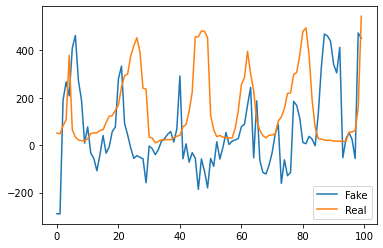

In [61]:
#### Example ####

batch_size = 1

# create noise
noise = np.abs(np.random.randn(batch_size,noise_size))

# fake
x_fake = G.predict(noise)
y_fake = D.predict(x_fake)

# real
x_real = np.array([sample_data_pp(num=100)[0] for i in range(batch_size)])
y_real = D.predict(x_real)

# y_fake,y_real

# plt.figure(figsize=(15,6))
plt.plot(np.transpose(x_fake*x_max),label='Fake')
plt.plot(np.transpose(x_real*x_max),label='Real')
plt.legend();
plt.show();

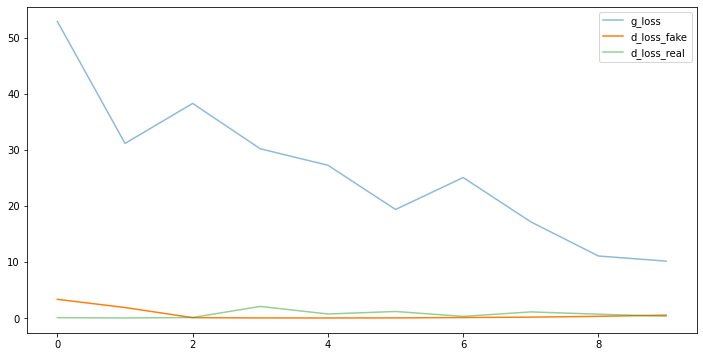

In [17]:
plt.figure(figsize=(12,6))
g_loss,d_loss_fake,d_loss_real
plt.plot(g_loss,label='g_loss',alpha=0.5)
plt.plot(d_loss_fake,label='d_loss_fake')
plt.plot(d_loss_real,label='d_loss_real',alpha=0.5)
plt.legend()
plt.show();

ModuleNotFoundError: No module named 'tensorflow.keras.layers.advanced_activations'

# W-Gan
- RMSprop Optimizer
- Wasserstein Loss Function
- clipping values (checked - and it's not helpfull in this case)
- learning ratio (for every itreation of G, D will have n iterations)

In [123]:
D_rmsprop_optimizer = RMSprop(lr=0.003)
G_rmsprop_optimizer = RMSprop(lr=0.001)
wasserstein_loss = lambda y_true,y_pred: mean(y_true * y_pred)
clip_value = 0.01
d_iterations = 5

noise_size = 15


def create_G(num=100):
    G_in = Input(shape=noise_size)
    x = Reshape((-1,1))(G_in)
    x = Conv1D(2,3,activation=LeakyReLU())(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Conv1D(4,3,activation=LeakyReLU())(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Conv1D(8,3,activation=LeakyReLU())(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Conv1D(16,3,activation=LeakyReLU())(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Conv1D(32,3,activation=LeakyReLU())(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Conv1D(64,3,activation=LeakyReLU())(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Conv1D(100,3,activation='tanh')(x)
    x = Flatten()(x)
    G = Model(G_in,x,name='Generator')
    G.compile(loss=wasserstein_loss,optimizer=rmsprop_optimizer)
    return G

def create_D(num=100):
    D_in = Input(shape=num)
    x = Reshape((-1,1))(D_in)
    x = Conv1D(num/2,3,activation=LeakyReLU())(x)
    x = Conv1D(num/10,3,activation=LeakyReLU())(x)
    x = Conv1D(num/50,3,activation=LeakyReLU())(x)
    x = Flatten()(x)
    x = Dense(128,activation=LeakyReLU())(x)
    x = Dropout(0.5)(x)
    x = Dense(64,activation=LeakyReLU())(x)
    x = Dropout(0.5)(x)
    x = Dense(32,activation=LeakyReLU())(x)
    x = Dropout(0.5)(x)
    x = Dense(8,activation=LeakyReLU())(x)
    x = Dense(2,activation='sigmoid')(x)
    D = Model(D_in,x,name='Discriminator')
    D.compile(loss=wasserstein_loss,optimizer=rmsprop_optimizer)
    return D

def create_GAN(G,D,num=100):
    D.trainable = False
    GAN_in = Input(shape=15)
    x = G(GAN_in)
    x = D(x)
    model = Model(GAN_in,x,name='GAN')
    model.compile(loss=wasserstein_loss,optimizer=rmsprop_optimizer)
    return model

D = create_D()
G = create_G()
GAN = create_GAN(G,D)

# Sanity check:
data_temp = sample_data_pp(num=noise_size)
print(data_temp.shape,G(data_temp).shape,D(G(data_temp)).shape,GAN(data_temp).shape,'\n')

data_temp = np.array([sample_data_pp(num=noise_size)[0] for i in range(3)])
print(data_temp.shape,G(data_temp).shape,D(G(data_temp)).shape,GAN(data_temp).shape,GAN(data_temp))

(2, 15) (2, 100) (2, 2) (2, 2) 

(3, 15) (3, 100) (3, 2) (3, 2) tf.Tensor(
[[0.49997127 0.49995613]
 [0.50007766 0.49992597]
 [0.49998057 0.50002325]], shape=(3, 2), dtype=float32)


In [124]:
def trainable_D(D,trainable):
    D.trainable = trainable
    for layer in D.layers:
        layer.trainable = trainable

def train_D(GAN,G,D,on_pray=True):
    # samples size  (batch)
    batch_size = 15

    # set_trainability
    trainable_D(D,True)

    # create noise
    noise = np.abs(np.random.randn(batch_size,noise_size))

    # fake
    x_fake = G.predict(noise)
    y_fake = np.zeros((batch_size,2)) + 0.1 # 0.1 instead of 0 - to evoid mode collapse 
    y_fake[:,0] = 0.9                       # 0.9 instead of 1 - to evoid mode collapse 
    loss_fake = D.train_on_batch(x_fake,y_fake)

    # real - PREY
    if on_pray:
        x_real = np.array([sample_data_pp(num=100)[0] for i in range(batch_size)])
    else:
        x_real = np.array([sample_data_pp(num=100)[1] for i in range(batch_size)])
    
    y_real = np.zeros((batch_size,2)) + 0.1 # 0.1 instead of 0 - to evoid mode collapse 
    y_real[:,1] = 0.9                       # 0.9 instead of 1 - to evoid mode collapse 
    loss_real = D.train_on_batch(x_real,y_real)

    # Clip D's weights
#     for l in D.layers:
#         weights = l.get_weights()
#         weights = [np.clip(w, -clip_value, clip_value) for w in weights]
#         l.set_weights(weights)
    
    return loss_fake,loss_real

  

def train_G(GAN,G,D):

    # samples size  (batch)
    batch_size = 15

    # set_trainability
    G.trainable = True
    trainable_D(D,False)

    # create noise
    noise = np.abs(np.random.randn(batch_size,noise_size))

    # fake
    # x_fake = G.predict(noise)
    y_fake = np.zeros((batch_size,2))
    y_fake[:,1] = 1
    loss = GAN.train_on_batch(noise,y_fake)
    
    # Clip G's weights
#     for l in G.layers:
#         weights = l.get_weights()
#         weights = [np.clip(w, -clip_value, clip_value) for w in weights]
#         l.set_weights(weights)

    return loss

train_D(GAN,G,D), train_G(GAN,G,D)

((0.24982093274593353, 0.24473287165164948), 0.22875836491584778)

In [126]:
def train(GAN, G, D, epochs=1000, n_samples=100, verbose=True):
    d_loss_fake = []
    d_loss_real = []
    g_loss = []
    e_range = range(epochs)
    
    if verbose:
        e_range = tqdm(e_range)
    
    for epoch in e_range:
        
        for _ in range(d_iterations):
            loss_fake,loss_real = train_D(GAN,G,D)
            d_loss_fake.append(loss_fake)
            d_loss_real.append(loss_real)
        
        loss = train_G(GAN,G,D)
        g_loss.append(loss)
        
        if verbose and ((epoch+1)%(epochs//10)==0):
            print("Epoch #{}:\t Generative Loss: {}".format(epoch+1, g_loss[-1]))
            print("          \t Discriminative Loss fake: {}, Discriminative Loss real: {}\n".format(d_loss_fake[-1], d_loss_real[-1]))
            
    return g_loss,d_loss_fake,d_loss_real

g_loss,d_loss_fake,d_loss_real = train(GAN, G, D, verbose=True)

Epoch #100:	 Generative Loss: 3.109935608993446e-33
          	 Discriminative Loss fake: 1.6358589815133672e-16, Discriminative Loss real: 0.0

Epoch #200:	 Generative Loss: 6.1776847461167956e-34
          	 Discriminative Loss fake: 3.1702345087848575e-35, Discriminative Loss real: 5.006750039198597e-28

Epoch #300:	 Generative Loss: 0.0
          	 Discriminative Loss fake: 1.247377580989216e-35, Discriminative Loss real: 3.7517979892758384e-32

Epoch #400:	 Generative Loss: 0.0
          	 Discriminative Loss fake: 0.0, Discriminative Loss real: 0.0

Epoch #500:	 Generative Loss: 0.0
          	 Discriminative Loss fake: 0.0, Discriminative Loss real: 0.0

Epoch #600:	 Generative Loss: 2.9132631856750994e-36
          	 Discriminative Loss fake: 0.0, Discriminative Loss real: 0.0

Epoch #700:	 Generative Loss: 0.0
          	 Discriminative Loss fake: 2.7086564386991085e-06, Discriminative Loss real: 0.0

Epoch #800:	 Generative Loss: 0.0
          	 Discriminative Loss fake: 7.79

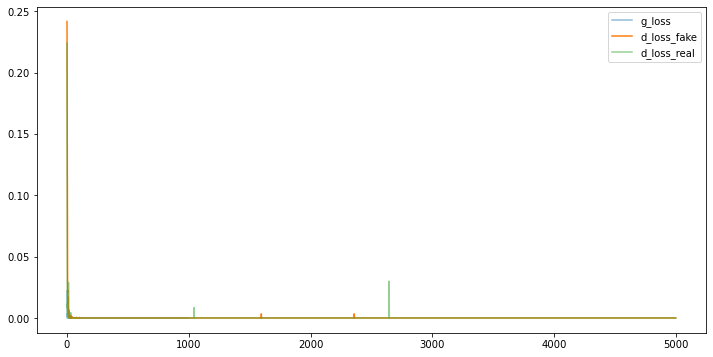

In [127]:
plt.figure(figsize=(12,6))
g_loss,d_loss_fake,d_loss_real
plt.plot(g_loss,label='g_loss',alpha=0.5)
plt.plot(d_loss_fake,label='d_loss_fake')
plt.plot(d_loss_real,label='d_loss_real',alpha=0.5)
plt.legend()
plt.show();

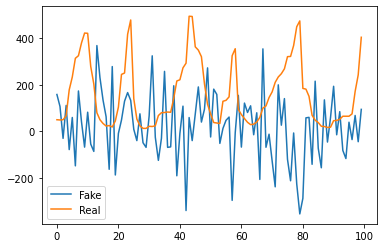

In [128]:
#### Example ####

batch_size = 1

# create noise
noise = np.abs(np.random.randn(batch_size,noise_size))

# fake
x_fake = G.predict(noise)
y_fake = D.predict(x_fake)

# real
x_real = np.array([sample_data_pp(num=100)[0] for i in range(batch_size)])
y_real = D.predict(x_real)

# y_fake,y_real

# plt.figure(figsize=(15,6))
plt.plot(np.transpose(x_fake*x_max),label='Fake')
plt.plot(np.transpose(x_real*x_max),label='Real')
plt.legend();
plt.show();